# Sentiment Analysis with Logistic Regression

In this final notebook we will combine all the other steps implemented in the other notebooks and  implement logistic regression for sentiment analysis on tweets.
Given a tweet, we will decide if it has a positive sentiment or a negative one. 

Specifically we will: 

* Extract features for logistic regression given some text
* Implement logistic regression from scratch
* Apply logistic regression on a natural language processing task (binary tweet classification)
* Test and perform error analysis

Lets get started!

We will be using a data set of tweets. 

## Table of Contents

- [Import Functions and Data](#0)
- [1 - Logistic Regression](#1)
    - [1.1 - Sigmoid](#1-1)
        - [1.1 - sigmoid](#1.1)
    - [1.2 - Cost function and Gradient](#1-2)
        - [1.2.1 - gradientDescent](#1.2.1)
- [2 - Extracting the Features](#2)
    - [2.1 - extract_features](#2.1)
- [3 - Training the Model](#3)
- [4 - Test our Logistic Regression](#4)
    - [4.1 - predict_tweet](#4.1)
    - [4.2.1 - Check the Performance using the Test Set](#4.2.1)
        - [4.2.1 - test_logistic_regression](#4.2.1)


<a name='0'></a>
## Import Functions and Data

In [1]:
# run this cell to import nltk

import nltk                         # NLP toolbox
from os import getcwd
import matplotlib.pyplot as plt     # Library for visualization

### Imported Functions

Now we will download the tweets data needed using 
```python
nltk.download('twitter_samples')
```
> [documentation for the twitter_samples dataset](http://www.nltk.org/howto/twitter.html).
- and download the stopwords list using:
```python
nltk.download('stopwords')
```



In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\skand\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Important helper functions provided in the utils.py file and discussed in detail in the other notebooks:

* process_tweet: cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.
* build_freqs: this counts how often a word in the 'corpus' (the entire set of tweets) was associated with a positive label '1' or a negative label '0', then builds the 'freqs' dictionary, where each key is the (word,label) tuple, and the value is the count of its frequency within the corpus of tweets.
* sigmoid: It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 

In [3]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

from utils import process_tweet, build_freqs, sigmoid

### Prepare the Data
* The `twitter_samples` contains subsets of five thousand positive_tweets, five thousand negative_tweets, and the full set of 10,000 tweets.  
    * If we use all three datasets, we would introduce duplicates of the positive tweets and negative tweets.  
> So we  will select just the five thousand positive tweets and five thousand negative tweets.

In [4]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

* Train test split: 20% will be in the test set, and 80% in the training set.


In [5]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

* Create the numpy array of positive labels and negative labels.

In [6]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [7]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


* Create the frequency dictionary using the imported build_freqs function.  
    * the implementation is the utils.py file as mentionned earlier

* The returned 'freqs' dictionary is a dictionary where:
    - The key is the tuple (word, label), such as ("happy",1) or ("happy",0).  
    - The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.

In [8]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11427


### Process Tweet
The given function 'process_tweet' tokenizes the tweet into individual words, removes stop words and applies stemming.

In [9]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


<a name='1'></a>
## 1 - Logistic Regression 

<a name='1-1'></a>
### 1.1 - Sigmoid
* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./images/sigmoid_plot.jpg' alt="alternate text" width="width" height="height" style="width:300px;height:200px;" /> Figure 1 </div>

#### Logistic Regression: Regression and a Sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

- the $\theta$ values are called "weights". we'll referto them using the variable $\theta$ 

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

We will refer to 'z' as the 'logits'.

<a name='1-2'></a>
### 1.2 - Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$

where:

* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value resulting in huge loss that we need to minimize by adjusting the weights of the model. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [10]:
# verify that when the model predicts close to 1, but the actual label is 0, 
# the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.99999999999999990) # loss is about big

36.7368005696771

* Likewise, if the model predicts close to 0 ($h(z) = 0.0001$) but the actual label is 1, the first term in the loss function becomes a large number: $-1 \times log(0.0001) \approx 9.2$.  The closer the prediction is to zero, the larger the loss.

In [11]:
# verify that when the model predicts close to 0 but the actual label is 1,
# the loss is a large positive value
-1 * np.log(0.000000000000000001) # loss is big

41.44653167389282

#### Update the weights

To update the weight vector $\theta$, we will apply the gradient descent algorithm to iteratively improve the model's weights and thus its predictions.  

The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


<a name='1.2.1'></a>
### 1.2.1 - gradientDescent
In the gradient descent function below:

* The number of iterations 'num_iters" is the number of times that we'll use the entire training set.
* For each iteration, we'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), we transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [12]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: the final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix x (# of training examples)
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1 / m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))

        # update the weights theta
        theta = theta - (alpha / m) * np.dot(x.T, (h - y))        

    J = float(J)
    return J, theta

<a name='2'></a>
## 2 - Extracting the Features

* Given a list of tweets, we will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 

* Then train our logistic regression classifier on these features.
* and finally test the performance of the classifier on a validation set. 

<a name='2.1'></a>
### 2.1 - extract_features
the extract_features function below :

- takes in a single tweet,
- processes the tweet using the imported `process_tweet` function and save the list of tweet words, 
- Loop through each word in the list of processed words
    * For each word, check the 'freqs' dictionary for the count when that word has a positive '1' label. (Check for the key (word, 1.0)
    * Do the same for the count for when the word is associated with the negative label '0'. (Check for the key (word, 0.0).)

In [13]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[1] += freqs.get((word, 1.0), 0)

        # Increment the word count for the negative label 0
        x[2] += freqs.get((word, 0.0), 0)
        
            
    x = x[None, :]  # adding batch dimension for further processing
    return x

<a name='3'></a>
## 3 - Training the Model

To train the model we:
* Stack the features for all training examples into a matrix X. to form (m,3) training matrix 
* Call `gradientDescent`, which we've implemented above.

In [14]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.22521264.
The resulting vector of weights is [6e-08, 0.0005382, -0.0005583]


C:\Users\skand\AppData\Local\Temp\ipykernel_35000\1015084994.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


## Plot the samples in a scatter plot

The vector theta represents a plane that split our feature space into two parts. Samples located over that plane are considered positive, and samples located under that plane are considered negative. Remember that we have a 3D feature space, i.e., each tweet is represented as a vector comprised of three values: `[bias, positive_sum, negative_sum]`, always having `bias = 1`. 

If we ignore the bias term, we can plot each tweet in a cartesian plane, using `positive_sum` and `negative_sum`. In the cell below, we do precisely this. Additionally, we color each tweet, depending on its class. Positive tweets will be green and negative tweets will be red.

C:\Users\skand\AppData\Local\Temp\ipykernel_35000\2162104075.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words


Text(0, 0.5, 'Negative')

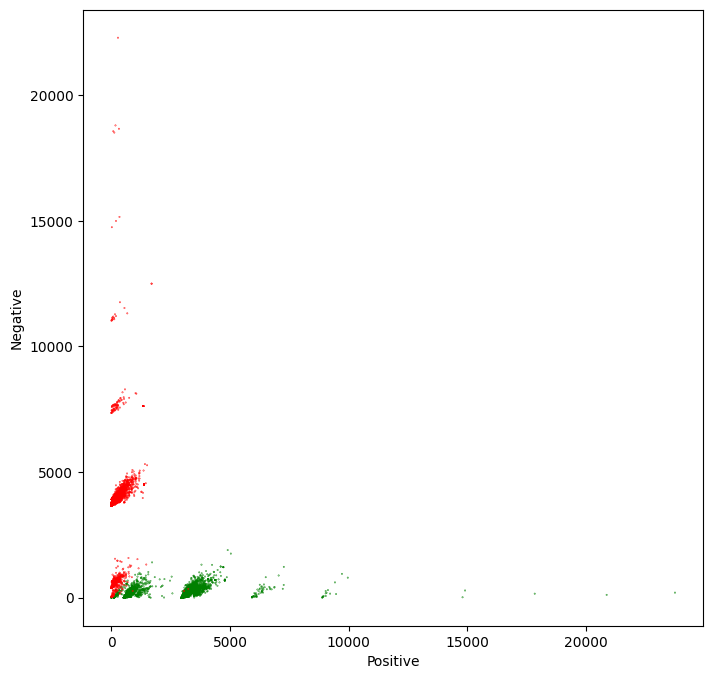

In [15]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']


# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

From the plot, it is evident that the features that we have calculated to represent tweets as numerical vectors allow an almost perfect separation between positive and negative tweets. So you can expect a very high accuracy for this model! 

## Plot the model alongside the data

We will draw a gray line to show the cutoff between the positive and negative regions. In other words, the gray line marks the line where $$ z = \theta * x = 0.$$
To draw this line, we have to solve the above equation in terms of one of the independent variables.

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

The red and green lines that point in the direction of the corresponding sentiment are calculated using a perpendicular line to the separation line calculated in the previous equations (neg function). It must point in the same direction as the derivative of the Logit function, but the magnitude may differ. It is only for a visual representation of the model. 

$$direction = pos * \theta_2 / \theta_1$$


In [16]:
# Equation for the separation plane
# It give a value in the negative axe as a function of a positive value
# f(pos, neg, W) = w0 + w1 * pos + w2 * neg = 0
# s(pos, W) = (-w0 - w1 * pos) / w2
def neg(theta, pos):
    return (-theta[0][0] - pos * theta[1][0]) / theta[2][0]

# Equation for the direction of the sentiments change
# We don't care about the magnitude of the change. We are only interested 
# in the direction. So this direction is just a perpendicular function to the 
# separation plane
# df(pos, W) = pos * w2 / w1
def direction(theta, pos):
    print (theta[2][0])
    return    pos * theta[2][0] / theta[1][0]

C:\Users\skand\AppData\Local\Temp\ipykernel_35000\3143752351.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words


-0.0005583031503756955
-0.0005583031503756955


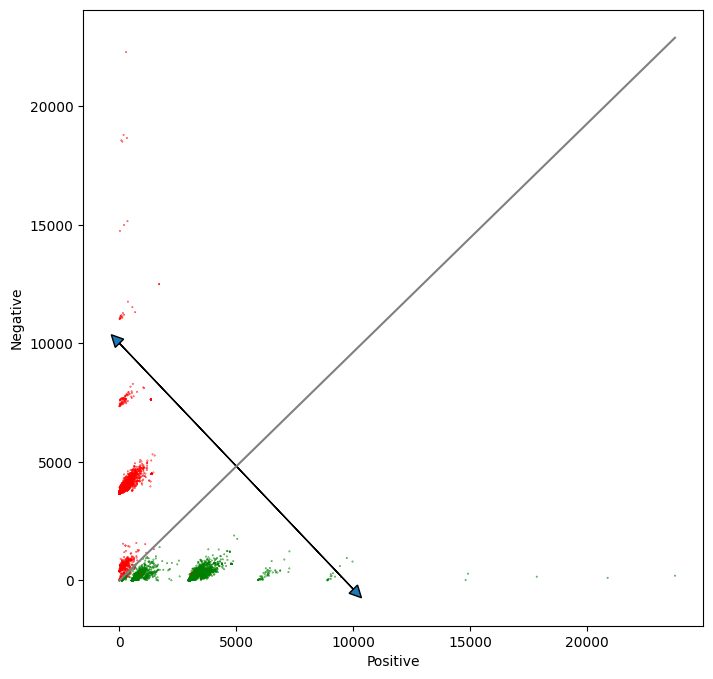

In [17]:
# The green line in the chart points in the direction where z > 0 and the red line points in the direction where z < 0. The direction of these lines are given by the weights $\theta_1$ and $\theta_2$
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")


# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])

offset = 5000 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500)

# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500)

plt.show()



<a name='4'></a>
## 4 -  Test our Logistic Regression

It is time for us to test the logistic regression function on some new input that the model has not seen before. 
<a name='4.1'></a>

## 4.1 - predict_tweet
the  `predict_tweet` function below predicts whether a tweet is positive or negative.

* Given a tweet, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [18]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)

    # Make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
        
    return y_pred

In [19]:
# Run this cell to test the function
for tweet in ['I am sad', 'I hate you', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))    
    

I am sad -> 0.486718
I hate you -> 0.494930
this movie should have been great. -> 0.515980
great -> 0.516065
great great -> 0.532097
great great great -> 0.548063
great great great great -> 0.563930


C:\Users\skand\AppData\Local\Temp\ipykernel_35000\1749426840.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))


<a name='4.2.1'></a>
### 4.2.1 -  Check the Performance using the Test Set
After Training the Model using the training set above, check how your model might perform on real, unseen data, by testing it against the test set.

the  `test_logistic_regression` function below does the following:

* Given the test data and the weights of our trained model, calculate the accuracy of the logistic regression model. 
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.

In [20]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # so we convert both to one-dimensional arrays in order to compare them using the '==' operator
    # Convert y_hat and test_y to numpy arrays
    y_hat = np.asarray(y_hat)
    y_true = np.squeeze(test_y)

    # Compare the predictions and true labels
    accuracy = np.mean((y_hat == y_true))
    
    return accuracy

In [21]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950
